In [2]:
import os
import json
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
import random

In [29]:
# os.makedirs(os.path.join("OPs_used","muscle","pic"), exist_ok=True)
# os.makedirs(os.path.join("OPs_used","skin","pic"), exist_ok=True)
# os.makedirs(os.path.join("OPs_used","fat","pic"), exist_ok=True)

tissue = "fat"
path = os.path.join("OPs_used", f"{tissue}")
os.makedirs(os.path.join("OPs_used",f"{tissue}","pic"), exist_ok=True)

In [31]:
with open(os.path.join("OPs_used", "wavelength.json"), 'r') as f:
    used_wl = json.load(f)
    used_wl = used_wl['wavelength']
# with open(os.path.join("OPs_used", "bloodConc.json"), 'r') as f:
#     bloodConc = json.load(f)
#     bloodConc = bloodConc['bloodConc']
bloodConc = [150]

    
# SO2_used = {'SO2': [i/100 for i in range(90,101,1)]}
# SO2_used = {'SO2': [0.9, 0.93, 0.94, 0.945, 0.949, 0.95, 0.951, 0.955, 0.96, 0.97, 1]}
# SO2_used = {'SO2': [0.65, 0.68, 0.69, 0.695, 0.699, 0.7, 0.701, 0.705, 0.71, 0.72, 0.75]}
SO2_used = {'SO2':[0.35,0.4,0.425,0.5,0.525,0.55,0.575,0.6,0.625,0.65,0.675,0.7,0.725,0.75,0.775,0.8,0.825,0.85,0.875,0.9,0.925,0.95]}
tissue_SO2_used = {'train_SO2':[0.35,0.4,0.5,0.6,0.7,0.75,0.8,0.85,0.9,0.95],
            'test_SO2':[0.35,0.4,0.425,0.5,0.55,0.575,0.6,0.65,0.675,0.7,0.725,0.75,0.775,0.8,0.825,0.85,0.875,0.9,0.925,0.95]
            }
#SO2_used = {'SO2': list(np.linspace(0.35,0.95,23))}

with open(os.path.join("OPs_used", "tissue_SO2.json"), 'w') as f:
    json.dump(tissue_SO2_used, f , indent=4)

with open(os.path.join(path, f"{tissue}_SO2.json"), 'w') as f:
    json.dump(SO2_used, f, indent=4)
SO2_used = SO2_used['SO2']

## Plot the result 
### compare the literature muscle mua spectrum and we build muscle mua spectrum by different substance concentrations.


## Get literature tissue(muscle、skin、fat) mua spectrum

In [32]:
# 從各波長的bound，選num條，組成線
def get_spec(used_wl, mua_bound, tissue, num):
    spec = {}
    for wl in used_wl:
        spec[f'{wl}nm'] = []
    for wl in used_wl:
        [mua_max, mua_min] = mua_bound[f'{wl}nm'][tissue]
        mua = list(np.linspace(mua_max,mua_min,num))
        for i in range(len(mua)):
            spec[f'{wl}nm'].append(mua[i])
    
    return spec

num = 3 # number of spectrum used
with open(os.path.join("OPs_used","mua_wl_bound.json"),"r") as f:
    mua_bound = json.load(f)

if tissue == 'muscle':
    muscle_mua_spec_literature = get_spec(used_wl, mua_bound, tissue, num)
    muscle_mua_spec_literature_numpy = pd.DataFrame(muscle_mua_spec_literature).to_numpy()
if tissue == 'skin':
    skin_mua_spec_literature = get_spec(used_wl, mua_bound, tissue, num)
    skin_mua_spec_literature_numpy = pd.DataFrame(skin_mua_spec_literature).to_numpy()
if tissue == 'fat':
    fat_mua_spec_literature = get_spec(used_wl, mua_bound, tissue, num)
    fat_mua_spec_literature_numpy = pd.DataFrame(fat_mua_spec_literature).to_numpy()

# print(skin_mua_spec_literature)

In [33]:
# get substanece ua
path_sub = os.path.join("OPs_used", "absorption", "absorption.xlsx")
file = pd.read_excel(path_sub, sheet_name='substance')
file = file.iloc[file.index[np.in1d(file['wl'],used_wl)]]

wl = file['wl'].to_numpy()
hbo2 = file['hbo2'].to_numpy()
hb = file['hb'].to_numpy()
water = file['water'].to_numpy()
col = file['col'].to_numpy()
mel = file['mel'].to_numpy()
lipid = file['lipid'].to_numpy()
base_col = col*2

## Get the muscle mua spectrum by setting substanece concentration mua and combine it.

In [16]:
# cal muscle ua
blood_ratio_m_list = [0.005, 0.015]


muscle_mua = {}
muscle_mua_plot = np.empty((len(bloodConc), len(SO2_used), len(used_wl))) 
for b_idx, blc in enumerate(bloodConc):
    muscle_mua_save = np.empty((len(SO2_used), len(used_wl)+1)) # record SO2 + wavelength
    for idx, SO2 in enumerate(SO2_used):
        
        blood_ratio = random.uniform(blood_ratio_m_list[0], blood_ratio_m_list[1])
        
        muscle_mua[f'{tissue}_mua_bloodConc_{blc}'] = (2.303*blood_ratio*blc*(hbo2*SO2+hb*(1-SO2))/64500 + 0.8*col + 0.7*water + base_col)*0.1 # 0.1 cm->mm
        muscle_mua_plot[b_idx][idx] = muscle_mua[f'{tissue}_mua_bloodConc_{blc}']
        muscle_mua_save[idx] = np.array([SO2]+list(muscle_mua[f'{tissue}_mua_bloodConc_{blc}']))
    columns = ['SO2'] + [f'{wl}_nm' for wl in used_wl]
    muscle_mua_save = pd.DataFrame(muscle_mua_save, columns=columns)

    muscle_mua_save.to_csv(os.path.join( path, f"{tissue}_mua_bloodConc_{blc}.csv"), index=False)

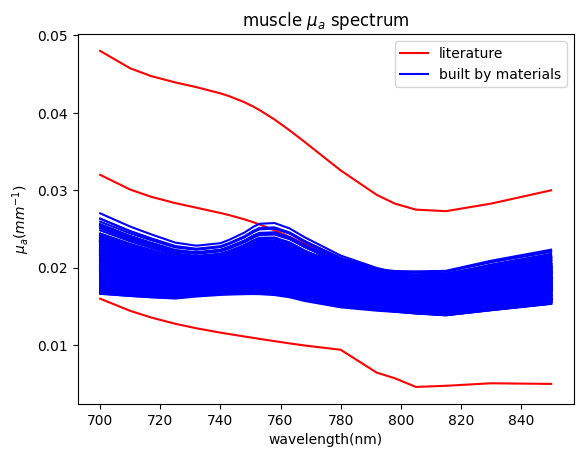

In [17]:
# os.makedirs(os.path.join("pic"), exist_ok=True)
spec_numpy = pd.DataFrame(muscle_mua_spec_literature).to_numpy()
for i in range(spec_numpy.shape[0]):
    if i == 0:
        plt.plot(used_wl,spec_numpy[i], 'r', label='literature')
    else:
        plt.plot(used_wl,spec_numpy[i], 'r')
for b_idx in range(len(bloodConc)):
    for s_idx in range(len(SO2_used)):
        if b_idx==0 and s_idx == 0:
            plt.plot(wl, muscle_mua_plot[b_idx][s_idx], 'b', label=f'built by materials')
        else:
            plt.plot(wl, muscle_mua_plot[b_idx][s_idx], 'b')
plt.xlabel('wavelength(nm)')
plt.ylabel("$\mu_a$($mm^{-1}$)")
plt.title(f'{tissue} $\mu_a$ spectrum')
plt.legend()
plt.savefig(os.path.join(path,"pic", f'{tissue}_mua_{blood_ratio}_spectrum.png'), dpi=300, format='png', bbox_inches='tight')
plt.show()

# plt.plot(col)
# plt.xlabel('wavelength(nm)')
# plt.ylabel("$\mu_a$($mm^{-1}$)")
# plt.title(f'collagen $\mu_a$ spectrum')
# plt.legend()
# plt.savefig(os.path.join(path,"pic", 'collagen_mua_spectrum.png'), dpi=300, format='png', bbox_inches='tight')
# plt.show()

In [18]:
# Get muscle_with_blood mua
muscle_mua_spec = {}
for blc in bloodConc:
    spec = pd.read_csv(os.path.join(path, f"muscle_mua_bloodConc_{blc}.csv"))
    spec = spec.to_numpy()
    for s_idx, SO2 in enumerate(SO2_used):
        muscle_mua_spec[f'muscle_bloodConc_{blc}_bloodSO2_{SO2}'] = list(spec[s_idx][1:]) # first element(0-index) represent SO2

with open(os.path.join(path, f'{tissue}_mua_spectrum.json'), 'w') as f:
    json.dump(muscle_mua_spec, f, indent=4)

## Get the skin mua spectrum by setting substanece concentration mua and combine it.

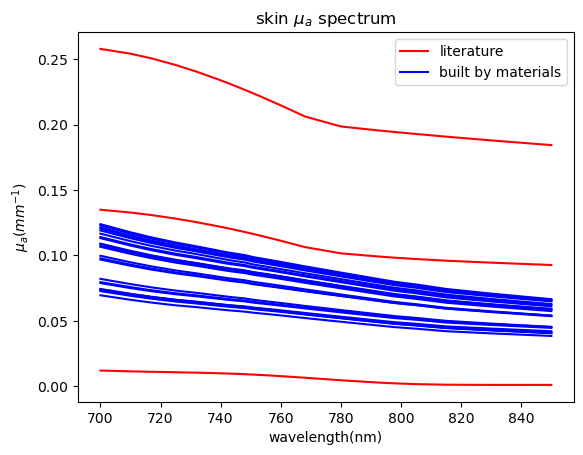

In [27]:
# cal skin ua
blood_ratio_skin_list = [0.001, 0.005]
f_water_bound_list = [0.66, 0.78] # [ min, max]
f_mel_bound_list = [0.003, 0.006] # [min, max]
f_col_bound_list = [0.1, 0.2] # [min, max]

skin_mua = {}
skin_mua_plot = np.empty((len(bloodConc), len(SO2_used), len(used_wl))) 
for b_idx, blc in enumerate(bloodConc):
    skin_mua_save = np.empty((len(SO2_used), len(used_wl)+1)) # record SO2 + wavelength
    for idx, SO2 in enumerate(SO2_used):

        f_water = random.uniform(f_water_bound_list[0], f_water_bound_list[1])
        f_mel = random.uniform(f_mel_bound_list[0], f_mel_bound_list[1])
        f_col = random.uniform(f_col_bound_list[0], f_col_bound_list[1])
        blood_ratio = random.uniform(blood_ratio_skin_list[0], blood_ratio_skin_list[1])
        
        skin_mua[f'{tissue}_mua_bloodConc_{blc}'] = (2.303* blood_ratio* blc* ((hbo2*SO2+hb*(1-SO2))/64500) + 
                                                     f_col* col + f_water* water + f_mel* mel)*0.1
        skin_mua_plot[b_idx][idx] = skin_mua[f'{tissue}_mua_bloodConc_{blc}']
        skin_mua_save[idx] = np.array([SO2]+list(skin_mua[f'{tissue}_mua_bloodConc_{blc}']))
    columns = ['SO2'] + [f'{wl}_nm' for wl in used_wl]
    skin_mua_save = pd.DataFrame(skin_mua_save, columns=columns)

    skin_mua_save.to_csv(os.path.join( path, f"{tissue}_mua_bloodConc_{blc}.csv"), index=False)

spec_numpy = pd.DataFrame(skin_mua_spec_literature).to_numpy()
for i in range(spec_numpy.shape[0]):
    if i == 0:
        plt.plot(used_wl,spec_numpy[i], 'r', label='literature')
    else:
        plt.plot(used_wl,spec_numpy[i], 'r')
for b_idx in range(len(bloodConc)):
    for s_idx in range(len(SO2_used)):
        if b_idx==0 and s_idx == 0:
            plt.plot(wl, skin_mua_plot[b_idx][s_idx], 'b', label=f'built by materials')
        else:
            plt.plot(wl, skin_mua_plot[b_idx][s_idx], 'b')
plt.xlabel('wavelength(nm)')
plt.ylabel("$\mu_a$($mm^{-1}$)")
plt.title(f'{tissue} $\mu_a$ spectrum')
plt.legend()
plt.savefig(os.path.join(path,"pic", f'{tissue}_mua_spectrum.png'), dpi=300, format='png', bbox_inches='tight')
plt.show()

In [28]:
# Get skin_with_blood mua
skin_mua_spec = {}
for blc in bloodConc:
    spec = pd.read_csv(os.path.join(path, f"{tissue}_mua_bloodConc_{blc}.csv"))
    spec = spec.to_numpy()
    for s_idx, SO2 in enumerate(SO2_used):
        skin_mua_spec[f'{tissue}_bloodSO2_{SO2}'] = list(spec[s_idx][1:]) # first element(0-index) represent SO2

with open(os.path.join(path, f'{tissue}_mua_spectrum.json'), 'w') as f:
    json.dump(skin_mua_spec, f, indent=4)

## Get the fat mua spectrum by setting substanece concentration mua and combine it.

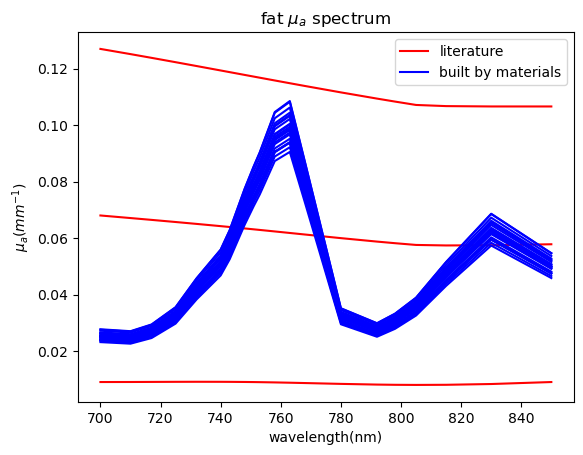

In [36]:
# cal fat ua
blood_ratio_fat_list = [0.0001, 0.0005]

f_water_bound_list = [0.1, 0.2] # [ min, max]
f_fat_bound_list = [0.7, 0.85] # [min, max]


fat_mua = {}
fat_mua_plot = np.empty((len(bloodConc), len(SO2_used), len(used_wl))) 
for b_idx, blc in enumerate(bloodConc):
    fat_mua_save = np.empty((len(SO2_used), len(used_wl)+1)) # record SO2 + wavelength
    for idx, SO2 in enumerate(SO2_used):
        
        f_water = random.uniform(f_water_bound_list[0], f_water_bound_list[1])
        f_fat = random.uniform(f_fat_bound_list[0], f_fat_bound_list[1])

        blood_ratio = random.uniform(blood_ratio_fat_list[0], blood_ratio_fat_list[1])
        
        fat_mua[f'{tissue}_mua_bloodConc_{blc}'] =(2.303*blood_ratio*blc*(hbo2*SO2+hb*(1-SO2))/64500 
                                                   + f_fat*lipid + f_water*water)*0.1
        fat_mua_plot[b_idx][idx] = fat_mua[f'{tissue}_mua_bloodConc_{blc}']
        fat_mua_save[idx] = np.array([SO2]+list(fat_mua[f'{tissue}_mua_bloodConc_{blc}']))
    columns = ['SO2'] + [f'{wl}_nm' for wl in used_wl]
    fat_mua_save = pd.DataFrame(fat_mua_save, columns=columns)

    fat_mua_save.to_csv(os.path.join( path, f"{tissue}_mua_bloodConc_{blc}.csv"), index=False)

spec_numpy = pd.DataFrame(fat_mua_spec_literature).to_numpy()
for i in range(spec_numpy.shape[0]):
    if i == 0:
        plt.plot(used_wl,spec_numpy[i], 'r', label='literature')
    else:
        plt.plot(used_wl,spec_numpy[i], 'r')
for b_idx in range(len(bloodConc)):
    for s_idx in range(len(SO2_used)):
        if b_idx==0 and s_idx == 0:
            plt.plot(wl, fat_mua_plot[b_idx][s_idx], 'b', label=f'built by materials')
        else:
            plt.plot(wl, fat_mua_plot[b_idx][s_idx], 'b')
plt.xlabel('wavelength(nm)')
plt.ylabel("$\mu_a$($mm^{-1}$)")
plt.title(f'{tissue} $\mu_a$ spectrum')
plt.legend()
plt.savefig(os.path.join(path,"pic", f'{tissue}_mua_spectrum.png'), dpi=300, format='png', bbox_inches='tight')
plt.show()

In [31]:
# Get fat_with_blood mua
fat_mua_spec = {}
for blc in bloodConc:
    spec = pd.read_csv(os.path.join(path, f"{tissue}_mua_bloodConc_{blc}.csv"))
    spec = spec.to_numpy()
    for s_idx, SO2 in enumerate(SO2_used):
        fat_mua_spec[f'{tissue}_bloodSO2_{SO2}'] = list(spec[s_idx][1:]) # first element(0-index) represent SO2

with open(os.path.join(path, f'{tissue}_mua_spectrum.json'), 'w') as f:
    json.dump(fat_mua_spec, f, indent=4)